In [ ]:
# In this notebook you will find the preprocessing of the embeddings 
# and 2 methodologies
# one method using random forest classifier and one method using keras

# Method 1:
#     Using session embeddings try to predict and embedding that will represent an item
#     Compare this embedding to the item embeddings
#     Recommend the top K items

# Method 2:
#    Multilabel classification using keras
#    For a given item embedding predict directly the item
#    Items are represented using label encoder and converted to categorical


In [22]:
import calendar
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.decomposition import PCA
import math
import random

In [23]:
# read data
item_features = pd.read_csv('dressipi_recsys2022/item_features.csv', sep=',')
clusters = pd.read_csv('clustered_features.csv')
purchases = pd.read_csv('train_purchases_cleanned.csv')
sessions = pd.read_csv('train_sessions_cleanned.csv')
cand_items = pd.read_csv('dressipi_recsys2022/candidate_items.csv', sep=',')


# train_purchases = pd.read_csv('dressipi_recsys2022/train_purchases.csv', sep=',')
# train_sessions = pd.read_csv('dressipi_recsys2022/train_sessions.csv', sep=',')
# purchases = train_purchases
# sessions = train_sessions

purchases = purchases[purchases.item_id.isin(cand_items.item_id)]
sessions = sessions[sessions.session_id.isin(purchases.session_id)]

In [28]:
# create embeddings for each item
item_embeddings = pd.concat(
            [item_features,pd.get_dummies(item_features['feature_category_id'])],axis=1
            )\
            .drop(['feature_value_id','feature_category_id'],axis=1)\
            .groupby('item_id').sum()\
            .reset_index()
item_embeddings.head()

,item_id,1,2,3,4,5,6,7,8,9,...,64,65,66,67,68,69,70,71,72,73
0,2,0,0,0,0,0,0,1,0,0,...,0,0,0,0,1,1,0,0,1,0
1,3,0,0,1,1,1,0,1,0,0,...,0,1,0,0,1,1,0,0,1,1
2,4,0,0,1,1,1,0,1,0,0,...,0,1,0,0,1,1,0,0,1,1
3,7,0,0,0,0,0,0,1,0,0,...,0,0,0,0,1,1,0,0,1,0
4,8,0,0,1,1,1,0,1,0,0,...,0,1,0,0,1,1,0,0,1,1


In [29]:
# create embeddings for each session
session_embeddings = sessions.merge(item_embeddings,on='item_id')\
                                    .drop(['date','item_id'],axis=1)\
                                    .groupby('session_id').sum()\
                                    .reset_index()
session_embeddings.head()

,session_id,1,2,3,4,5,6,7,8,9,...,64,65,66,67,68,69,70,71,72,73
0,13,0,0,0,1,0,1,1,0,0,...,0,1,0,0,1,1,0,0,1,0
1,113,0,0,4,6,4,2,6,0,0,...,0,6,0,0,6,6,0,0,6,6
2,140,0,0,0,3,0,0,3,0,0,...,0,0,0,0,3,3,0,0,3,3
3,153,0,0,0,3,0,0,3,0,0,...,0,0,0,0,3,3,0,0,3,3
4,154,0,0,0,1,0,0,1,0,0,...,0,0,0,0,1,1,0,0,1,1


In [30]:
# use item embeddings on purchases
purchases_embeddings = purchases.merge(item_embeddings,on='item_id').drop(['date'],axis=1)
purchases_embeddings.head()


,session_id,item_id,1,2,3,4,5,6,7,8,...,64,65,66,67,68,69,70,71,72,73
0,13,18626,0,0,1,1,1,0,1,1,...,0,0,0,0,1,1,0,0,1,1
1,20336,18626,0,0,1,1,1,0,1,1,...,0,0,0,0,1,1,0,0,1,1
2,27879,18626,0,0,1,1,1,0,1,1,...,0,0,0,0,1,1,0,0,1,1
3,40121,18626,0,0,1,1,1,0,1,1,...,0,0,0,0,1,1,0,0,1,1
4,41591,18626,0,0,1,1,1,0,1,1,...,0,0,0,0,1,1,0,0,1,1


In [31]:
# split data to random train and test
train_data = session_embeddings.merge(purchases_embeddings,on='session_id')
print(train_data.shape)
train_data.to_csv('test_train_data.csv')


xc = [col for col in train_data.columns if str(col)[-1]=='x']
xy = [col for col in train_data.columns if str(col)[-1]=='y']


train_session_ids = train_data.sample(frac=0.9).session_id.tolist()
test_session_ids = train_data[~train_data.session_id.isin(train_session_ids)]['session_id'].tolist()


x_train = train_data[train_data.session_id.isin(train_session_ids)][xc]
y_train = train_data[train_data.session_id.isin(train_session_ids)][xy]


x_test  = train_data[train_data.session_id.isin(test_session_ids)][xc]
y_test  = train_data[train_data.session_id.isin(test_session_ids)][xy]




(255335, 148)


In [32]:
len(test_session_ids),len(train_session_ids)

(25533, 229802)

In [33]:
rfclf = RandomForestClassifier( max_depth=50,random_state=0,n_estimators=20,n_jobs=-1)
rfclf.fit(x_train, y_train)

RandomForestClassifier(max_depth=50, n_estimators=20, n_jobs=-1, random_state=0)

In [13]:
import warnings
warnings.filterwarnings("ignore")
correct = 0
counter = 0
samples= 10000
for xV,yV in zip(x_test.values,y_test.values):
    prediction = rfclf.predict([xV])
    counter +=1
    if list(prediction[0]) == list(yV):
        correct +=1
    if counter > samples:
        break
        
print("True positive:",correct, "out of:",samples)


411 1000
830 2000
1262 3000
1688 4000
2112 5000
2549 6000
2979 7000
3434 8000
3840 9000
4269 10000
4722 11000
5142 12000
5555 13000


KeyboardInterrupt: 

In [45]:
from sklearn.metrics.pairwise import cosine_similarity


rec_from = item_embeddings[item_embeddings.item_id.isin(cand_items.item_id)]
rec_from = item_embeddings[item_embeddings.item_id.isin(purchases.item_id)]

class topN_results:
    def __init__(self):
        self.correct = 0
        
        
    def plus_one(self,n_top,results,y_true):
        if y_true in results[:n_top]:
            self.correct +=1


            
top1000 = topN_results()
top500 = topN_results()
top200 = topN_results()
top100 = topN_results()
top50 = topN_results()
top20 = topN_results()
top10 = topN_results()
top5 = topN_results()
top1 = topN_results()
counts = 0

samples = 100
test_ssid = train_session_ids[1]
for i in test_session_ids[:samples]:
    # For a given session id use the classifier and predict the embedding of the item he will purchase
    # Compare the embedding using cosine similarity with all the item embeddings, and rank them based 
    # on the similarity
    # recommend the top k items
    
    # get the session embedding and predict the item
    test_ssid=i
    test_embeddings = train_data[train_data.session_id==test_ssid][xc]
    t = rfclf.predict(test_embeddings)
    
    # use y_true to evaluate the outcome
    y_true = train_data[train_data.session_id==test_ssid]['item_id'].values[0]

    
    # use cosine similarity to compare the output of the classifier with the item embeddings
    results = pd.DataFrame(cosine_similarity(t,rec_from.iloc[:,1:])).T
    results = pd.concat([results,pd.Series(rec_from['item_id'].tolist())],axis=1)
    results.columns = ['similarities','item_id']
    
    # Rank based on similarity
    results.sort_values(by='similarities',ascending=False,inplace=True)
    results = results.reset_index().drop('index',axis=1)
    results.drop_duplicates(subset='item_id',keep='first',inplace=True)

    # use the topN_results class to store the results
    top100.plus_one(100, results.item_id.tolist(), y_true )
    top50.plus_one(50, results.item_id.tolist(), y_true )
    top20.plus_one(20, results.item_id.tolist(), y_true )
    top10.plus_one(10, results.item_id.tolist(), y_true )
    top5.plus_one(5, results.item_id.tolist(), y_true )
    top1.plus_one(1, results.item_id.tolist(), y_true )


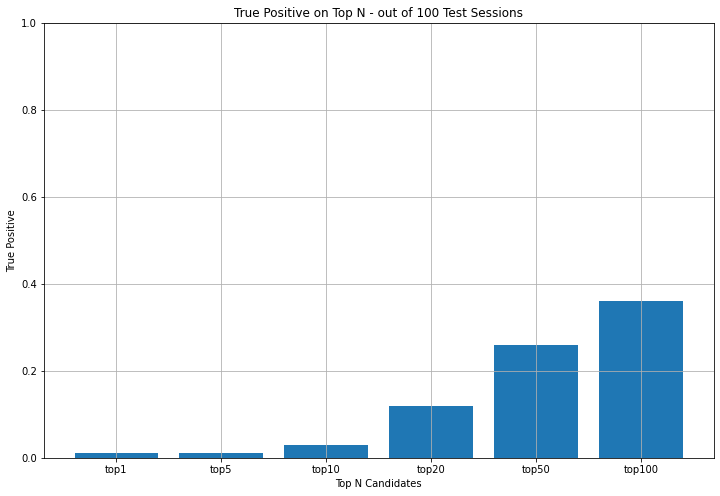

In [43]:
n_samples = len(test_session_ids[:samples])
tops = [top1.correct,top5.correct,top10.correct,top20.correct,
        top50.correct,top100.correct]
tops = [t/n_samples for t in tops]

plt.figure(figsize=(12,8))
plt.bar(['top1','top5','top10','top20','top50','top100'],tops)
plt.ylim(0,1)
plt.xlabel('Top N Candidates')
plt.ylabel('True Positive')
plt.grid()
plt.title(f'True Positive on Top N - out of {n_samples} Test Sessions')
plt.show()

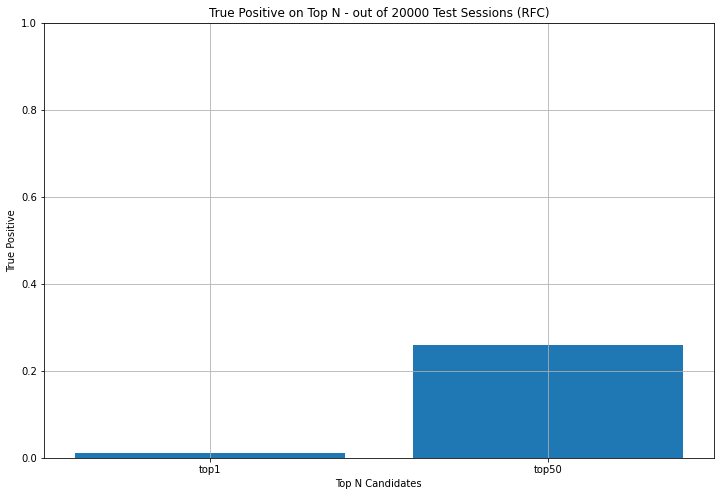

In [48]:
n_samples = len(test_session_ids[:samples])
tops = [top1.correct,
        top50.correct]
tops = [t/n_samples for t in tops]

plt.figure(figsize=(12,8))
plt.bar(['top1','top50'],tops)
plt.ylim(0,1)
plt.xlabel('Top N Candidates')
plt.ylabel('True Positive')
plt.grid()
plt.title(f'True Positive on Top N - out of {n_samples*200} Test Sessions (RFC)')
plt.show()

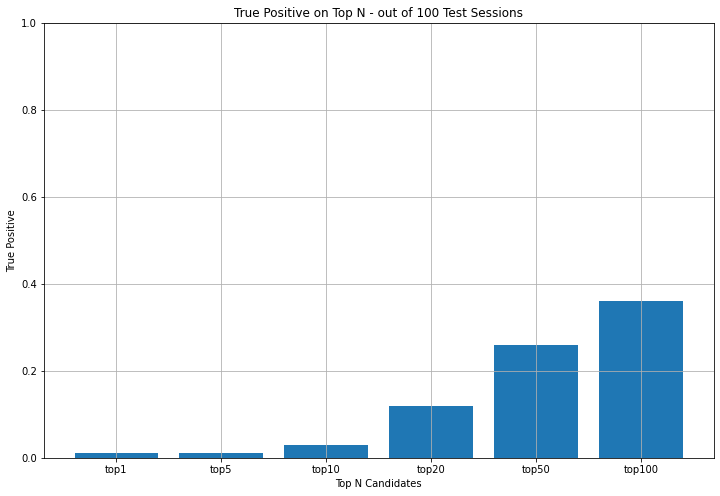

In [44]:
n_samples = len(test_session_ids[:samples])
tops = [top1.correct,top5.correct,top10.correct,top20.correct,
        top50.correct,top100.correct]
tops = [t/n_samples for t in tops]

plt.figure(figsize=(12,8))
plt.bar(['top1','top5','top10','top20','top50','top100'],tops)
plt.ylim(0,1)
plt.xlabel('Top N Candidates')
plt.ylabel('True Positive')
plt.grid()
plt.title(f'True Positive on Top N - out of {n_samples} Test Sessions')
plt.show()

In [148]:
pd.concat([train_data[xc],train_data.item_id],axis=1).to_csv('session_embeddings.csv')

# Create Model using Keras
# Classification with Neural Networks

In [ ]:

from sklearn.model_selection import train_test_split
import keras
import pandas as pd
import tensorflow as tf

df = pd.concat([train_data[xc],train_data.item_id],axis=1)
xc = [col for col in df.columns if str(col)[-1]=='x']

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(df.item_id)
df['labels'] = le.transform(df.item_id)

targets = tf.keras.utils.to_categorical(df.labels)


x_train,x_test,y_train,y_test = train_test_split(df[xc],targets,test_size=0.3)



In [ ]:
from keras import backend as K
import tensorflow as tf

from keras.layers import Dense,Dropout
model = keras.Sequential()
model.add(Dense(1800,input_dim=x_train.shape[1],activation='relu'))
model.add(Dense(1800,activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(1500,activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(1500,activation='relu'))
model.add(Dense(800,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(400,activation='relu'))
model.add(Dense(y_train.shape[1],activation='softmax'))
k20 = tf.keras.metrics.TopKCategoricalAccuracy(k=20)
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy',
                                                                        tf.keras.metrics.TopKCategoricalAccuracy(k=50)])
history = model.fit(x_train,y_train,epochs=10)

In [ ]:
model.evaluate(x_test)

In [ ]:
hist_ = pd.DataFrame(history.history)
hist_

import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.plot(hist_.index,hist_.loss)
plt.show()


plt.figure(figsize=(12,6))
plt.plot(hist_.index,hist_.accuracy)
plt.plot(hist_.index,hist_.top_k_categorical_accuracy)
plt.ylim(0,1)
plt.show()